Model Accuracy on Test Set: 98.00% 

Classifying image0.jpg...
Predicted Class: CABBAGE WHITE (99.46%)


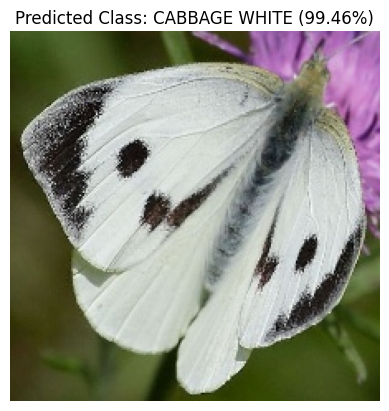

Classifying image1.jpg...
Predicted Class: MONARCH (99.43%)


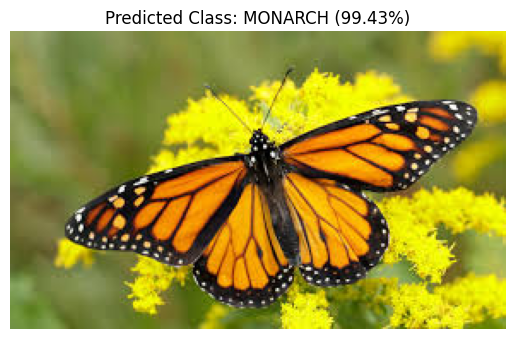

Classifying image2.jpg...
Predicted Class: SILVER SPOT SKIPPER (99.81%)


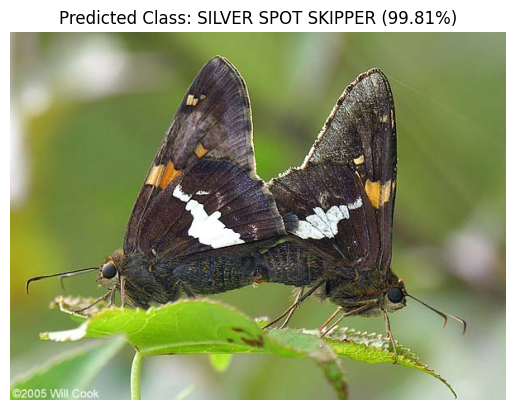

Classifying image3.jpg...
Predicted Class: VICEROY (86.05%)


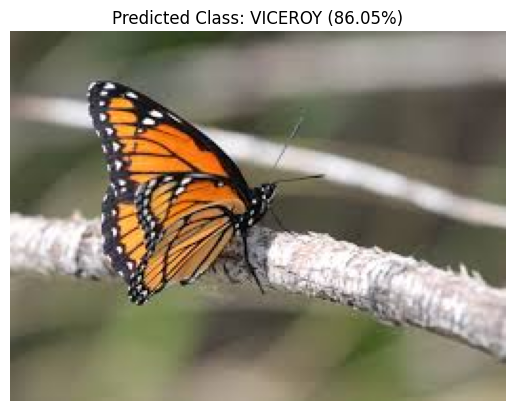

Classifying image4.jpeg...
Predicted Class: CHESTNUT (98.61%)


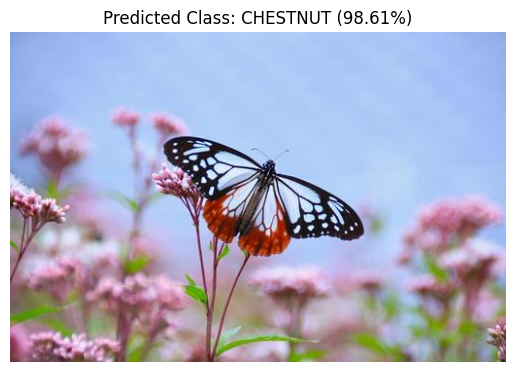

Classifying image5.jpg...
Predicted Class: GIANT LEOPARD MOTH (93.99%)


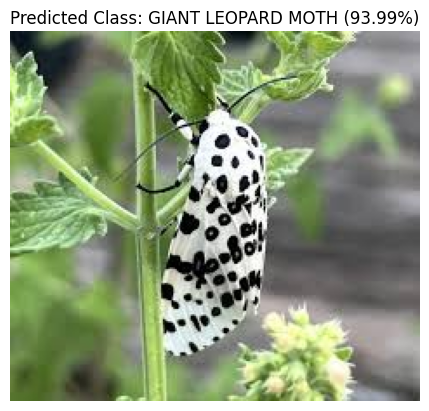

Classifying image6.jpeg...
Predicted Class: CHALK HILL BLUE (99.41%)


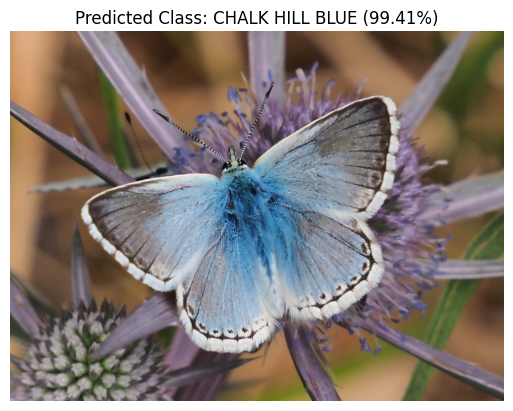

Classifying image7.jpg...
Predicted Class: ATLAS MOTH (99.85%)


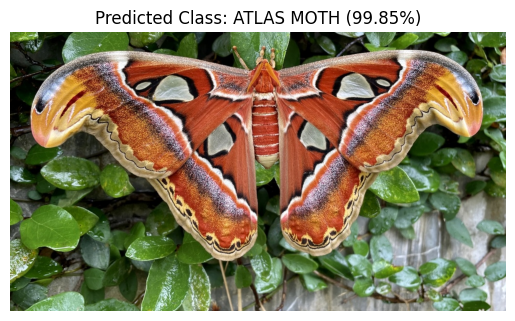

Classifying photo_2024-11-07_22-15-18.jpg...
Predicted Class: PEACOCK (89.81%)


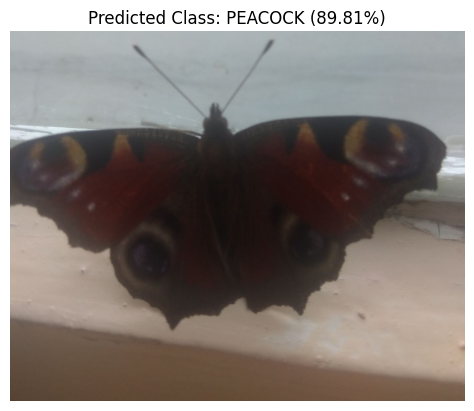

Classifying test1.jpg...
Not found


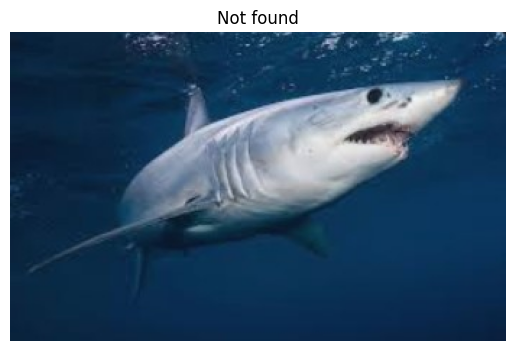

Classifying test2.jpg...
Not found


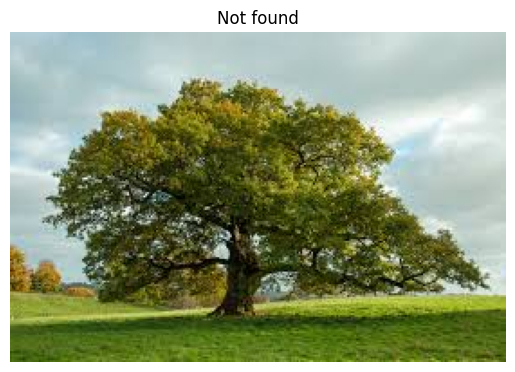

Total classified images: 11


In [3]:
import torch
from torchvision import transforms, models
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

# Constant
IMG_SIZE = 224
CONFIDENCE_THRESHOLD = 0.6
MODEL_PATH = 'butterfly_classifier_best.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Preparing the model (ResNet50)
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 100)  
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model = model.to(DEVICE)
model.eval()

# Classes
train_dataset = datasets.ImageFolder(root='dataset/butterfly/train/')
classes = train_dataset.classes

# Function for testing usage model
def evaluate_model(test_folder):
    test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    correct = 0
    total = len(test_loader)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print(f'Model Accuracy on Test Set: {accuracy:.2f}%','\n')

# Function for image classification and display
def classify_and_show_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)  

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)  
        confidence, predicted = torch.max(probabilities, 1)  
        confidence = confidence.item() * 100  
        predicted_class = classes[predicted.item()] if classes else f"Class {predicted.item()}"

    result_message = (f'Predicted Class: {predicted_class} ({confidence:.2f}%)'
                      if confidence >= CONFIDENCE_THRESHOLD * 100 else 'Not found')
    print(result_message)  

    plt.imshow(image)
    plt.title(result_message)
    plt.axis('off')
    plt.show()

# Function to categorize all images in a folder
def classify_images_in_folder(folder_path):
    classified_count = 0
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if os.path.isfile(image_path) and image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Classifying {filename}...")
            classify_and_show_image(image_path)
            classified_count += 1

    print(f'Total classified images: {classified_count}')


test_folder = 'dataset/butterfly/test/'  
evaluate_model(test_folder)  

folder_path = 'photo_test'  
classify_images_in_folder(folder_path)